In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve

#warnings
import warnings
warnings.filterwarnings("ignore")

**Data Cleaning**

In [2]:
df = pd.read_csv('../L&T Vehicle Loan Default Prediction/Dataset/train.csv')
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [3]:
df.isna().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

In [4]:
df.shape

(233154, 41)

In [5]:
def cns_desc(x):
    if x<300:
        return 0
    elif (x>=300) and (x<=350):
        return 1
    elif (x>350) and (x<=570):
        return 2
    elif (x>570) and (x<=630):
        return 3
    elif (x>630) and (x<=705):
        return 4
    else:
        return 5

In [6]:
df["Date.of.Birth"]=pd.to_datetime(df["Date.of.Birth"])

df["DisbursalDate"]=pd.to_datetime(df["DisbursalDate"])
df["DisbursalDate_Month"]=df["DisbursalDate"].dt.month

df["Age_at_disbursement"]=((df['DisbursalDate']-df["Date.of.Birth"])/365).apply(lambda x:x.days)

df["Employment.Type"]=df["Employment.Type"].map({'Salaried':0,"Self employed":1,np.nan:2})

df["PERFORM_CNS.SCORE.DESCRIPTION"]=df["PERFORM_CNS.SCORE"].apply(cns_desc)

df["AVERAGE.ACCT.AGE"]=df["AVERAGE.ACCT.AGE"].apply(lambda x:(int((x.split("y"))[0])*12)+(int((x.split())[1].split("m")[0])))

df["CREDIT.HISTORY.LENGTH"]=df["CREDIT.HISTORY.LENGTH"].apply(lambda x:(int((x.split("y"))[0])*12)+(int((x.split())[1].split("m")[0])))

<Axes: xlabel='Age_at_disbursement', ylabel='Density'>

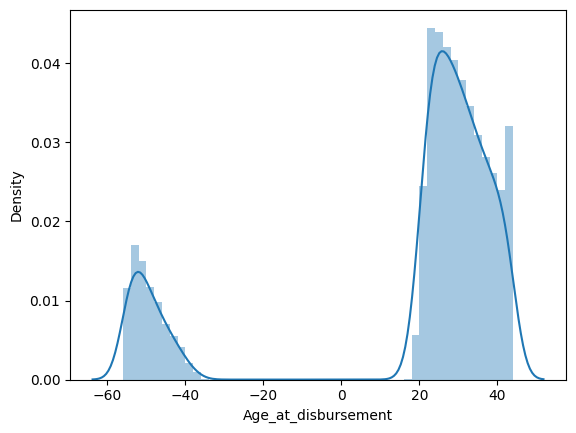

In [7]:
sns.distplot(df['Age_at_disbursement'])

In [8]:
df['NO.OF.ACCTS']=df['PRI.NO.OF.ACCTS']+df['SEC.NO.OF.ACCTS']
df['ACTIVE.ACCTS']=df['PRI.ACTIVE.ACCTS']+df['SEC.ACTIVE.ACCTS']
df['OVERDUE.ACCTS']=df['PRI.OVERDUE.ACCTS']+df['SEC.OVERDUE.ACCTS']
df['CURRENT.BALANCE']=df['PRI.CURRENT.BALANCE']+df['SEC.CURRENT.BALANCE']
df['SANCTIONED.AMOUNT']=df['PRI.SANCTIONED.AMOUNT']+df['SEC.SANCTIONED.AMOUNT']
df['DISBURSED.AMOUNT']=df['PRI.DISBURSED.AMOUNT']+df['SEC.DISBURSED.AMOUNT']
df['INSTAL.AMT']=df['PRIMARY.INSTAL.AMT']+df['SEC.INSTAL.AMT']

df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS','PRI.OVERDUE.ACCTS','SEC.OVERDUE.ACCTS','PRI.CURRENT.BALANCE','SEC.CURRENT.BALANCE','PRI.SANCTIONED.AMOUNT','SEC.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT','SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT'],axis=1)

In [9]:
df.nunique()

UniqueID                               233154
disbursed_amount                        24565
asset_cost                              46252
ltv                                      6579
branch_id                                  82
supplier_id                              2953
manufacturer_id                            11
Current_pincode_ID                       6698
Date.of.Birth                           15433
Employment.Type                             3
DisbursalDate                              84
State_ID                                   22
Employee_code_ID                         3270
MobileNo_Avl_Flag                           1
Aadhar_flag                                 2
PAN_flag                                    2
VoterID_flag                                2
Driving_flag                                2
Passport_flag                               2
PERFORM_CNS.SCORE                         573
PERFORM_CNS.SCORE.DESCRIPTION               6
NEW.ACCTS.IN.LAST.SIX.MONTHS      

In [10]:
df.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
       'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default',
       'DisbursalDate_Month', 'Age_at_disbursement', 'NO.OF.ACCTS',
       'ACTIVE.ACCTS', 'OVERDUE.ACCTS', 'CURRENT.BALANCE', 'SANCTIONED.AMOUNT',
       'DISBURSED.AMOUNT', 'INSTAL.AMT'],
      dtype='object')

In [11]:
df=df.drop(columns=['Date.of.Birth',"DisbursalDate"])

In [12]:
cols=df.columns.to_list()

In [13]:
cat_cols=['UniqueID','branch_id','supplier_id', 'manufacturer_id', 'Current_pincode_ID','Employment.Type', 'State_ID',
          'Employee_code_ID','MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag','Driving_flag', 'Passport_flag',
       'PERFORM_CNS.SCORE.DESCRIPTION','DisbursalDate_Month']

In [14]:
target_col="loan_default"

In [15]:
num_cols=['disbursed_amount','asset_cost','ltv','PERFORM_CNS.SCORE','NEW.ACCTS.IN.LAST.SIX.MONTHS',
          'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','NO.OF_INQUIRIES',
          'Age_at_disbursement','NO.OF.ACCTS','ACTIVE.ACCTS','OVERDUE.ACCTS','CURRENT.BALANCE','SANCTIONED.AMOUNT',
             'DISBURSED.AMOUNT','INSTAL.AMT']

In [16]:
df[cat_cols].nunique()

UniqueID                         233154
branch_id                            82
supplier_id                        2953
manufacturer_id                      11
Current_pincode_ID                 6698
Employment.Type                       3
State_ID                             22
Employee_code_ID                   3270
MobileNo_Avl_Flag                     1
Aadhar_flag                           2
PAN_flag                              2
VoterID_flag                          2
Driving_flag                          2
Passport_flag                         2
PERFORM_CNS.SCORE.DESCRIPTION         6
DisbursalDate_Month                  12
dtype: int64

As we see no of unique elements in some categorical columns is higher,we couldn't take dummies as it will cause curse of dimensionality => Drop them

In [17]:
linear_models_df=df.copy()

In [18]:
linear_models_df=linear_models_df.drop(columns=['UniqueID','supplier_id','Current_pincode_ID','Employee_code_ID',"MobileNo_Avl_Flag"])

In [19]:
cols_to_be_dummied=["branch_id","State_ID","manufacturer_id",'Employment.Type','DisbursalDate_Month','PERFORM_CNS.SCORE.DESCRIPTION']

In [20]:
linear_models_final_df=pd.get_dummies(data=linear_models_df,columns=cols_to_be_dummied,drop_first=True)

In [21]:
linear_models_df.corr()['loan_default']

disbursed_amount                       0.077675
asset_cost                             0.014261
ltv                                    0.098208
branch_id                              0.030193
manufacturer_id                       -0.025039
Employment.Type                        0.024823
State_ID                               0.048075
Aadhar_flag                           -0.041593
PAN_flag                               0.002046
VoterID_flag                           0.043747
Driving_flag                          -0.005821
Passport_flag                         -0.007602
PERFORM_CNS.SCORE                     -0.057929
PERFORM_CNS.SCORE.DESCRIPTION         -0.067798
NEW.ACCTS.IN.LAST.SIX.MONTHS          -0.029400
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.034462
AVERAGE.ACCT.AGE                      -0.024781
CREDIT.HISTORY.LENGTH                 -0.042126
NO.OF_INQUIRIES                        0.043678
loan_default                           1.000000
DisbursalDate_Month                    0

Since Current balance has negative values we will take scaled between 0 and 1

In [22]:
scalar=MinMaxScaler()
linear_models_final_df["CURRENT.BALANCE"]=scalar.fit_transform(linear_models_final_df["CURRENT.BALANCE"].values.reshape(-1,1))

In [23]:
val=[]
for i in num_cols:
    val.append(linear_models_df[i].skew())
skew_df=pd.DataFrame(index=num_cols,data=val,columns=["Scores"])
skew_df

,Scores
disbursed_amount,4.492240
asset_cost,6.133485
ltv,-1.075766
PERFORM_CNS.SCORE,0.445150
NEW.ACCTS.IN.LAST.SIX.MONTHS,4.839326
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,6.641996
AVERAGE.ACCT.AGE,3.285142
CREDIT.HISTORY.LENGTH,2.969155
NO.OF_INQUIRIES,7.870683
Age_at_disbursement,-1.609961


In [24]:
cols_to_taken_log=skew_df[skew_df["Scores"]>2].index

In [25]:
for i in cols_to_taken_log:
    linear_models_final_df[i]=np.log(linear_models_final_df[i]+1)

In [26]:
X=linear_models_final_df.drop('loan_default',axis=1)
y=linear_models_final_df['loan_default']
model_scores={}

In [27]:
linear_models_final_df.head()

,disbursed_amount,asset_cost,ltv,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,DisbursalDate_Month_8,DisbursalDate_Month_9,DisbursalDate_Month_10,DisbursalDate_Month_11,DisbursalDate_Month_12,PERFORM_CNS.SCORE.DESCRIPTION_1,PERFORM_CNS.SCORE.DESCRIPTION_2,PERFORM_CNS.SCORE.DESCRIPTION_3,PERFORM_CNS.SCORE.DESCRIPTION_4,PERFORM_CNS.SCORE.DESCRIPTION_5
0,10.831292,10.975088,89.55,1,0,0,0,0,0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,10.761004,11.090584,73.23,1,0,0,0,0,598,0.0,...,False,True,False,False,False,False,False,True,False,False
2,10.883298,11.024530,89.63,1,0,0,0,0,0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,10.959784,11.099136,88.48,1,0,0,0,0,305,0.0,...,False,False,True,False,False,True,False,False,False,False
4,10.866261,11.007104,88.39,1,0,0,0,0,0,0.0,...,False,True,False,False,False,False,False,False,False,False


In [28]:
linear_models_final_df.to_csv("data_fe.csv", index=False)